In [1]:
import urllib.request
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 데이터 가져오기
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

# 데이터 경로
TRAINING_DIR = "tmp/rps/"

# ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1. / 255, 
    rotation_range=5,           # 이미지 회전 
    width_shift_range=0.05,     # 가로 방향으로 이동
    height_shift_range=0.05,    # 세로 방향으로 이동
    zoom_range=0.05,            #  이미지 확대
    horizontal_flip=True,       # 횡 방향으로 이미지 반전
    fill_mode= 'reflect',       # 이미지를 이동이나 굴절시켰을때 빈 픽셀 값에 대하여 값을 채우는 방식
    validation_split=0.2        # train/validation 분할 비율
)

train_geneator = datagen.flow_from_directory(TRAINING_DIR,
                                             batch_size=32,
                                             class_mode='categorical',
                                             subset='training')

valid_genenator = datagen.flow_from_directory(TRAINING_DIR,
                                             batch_size=32,
                                             class_mode='categorical',
                                              subset='validation')

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


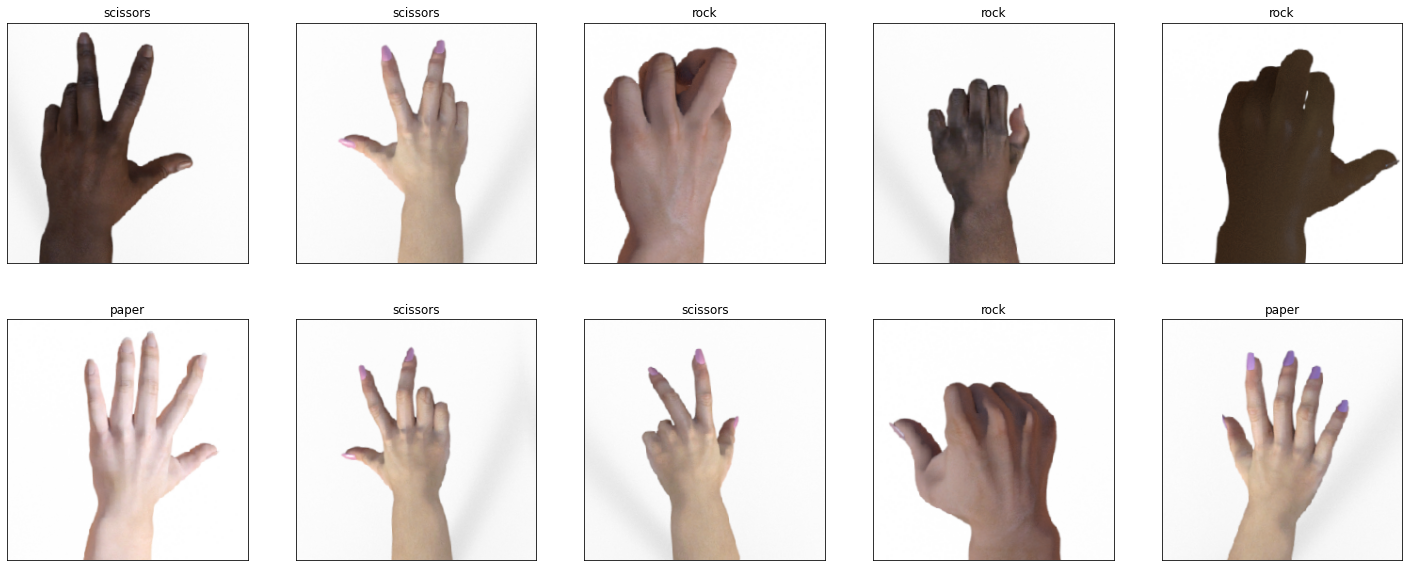

In [3]:
# 이미지 시각화
images = train_geneator[0][0][:10]
labels = train_geneator[0][1][:10]

fig, axes = plt.subplots(2,5, figsize=(25,10))

for idx, ax in enumerate(axes.flat):
    ax.tick_params(bottom=False, labelbottom=False,
                   left=False, labelleft=False)
    ax.imshow(images[idx])

    if labels[idx][0] == 1:
        ax.set_title('paper')
    elif labels[idx][1] == 1:
        ax.set_title('rock')
    else:
        ax.set_title('scissors')

plt.show()

In [4]:
# 모델링

## InceptionV3
transfer = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
transfer.trainable=False

model = tf.keras.models.Sequential([
                                    transfer,
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(3, activation='softmax')
])

In [5]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dropout (Dropout)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9437312   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 31,244,323
Trainable params: 9,441,539
Non-trainable params: 21,802,784
____________________________________

In [6]:
# 최적화 함수, 손실 함수, 평가 지표
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [7]:
# 체크 포인트 설정
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_loss',
                                                verbose=1)

In [8]:
# 모델 학습
hist = model.fit(train_geneator,
           validation_data = (valid_genenator),
           epochs=20,
           callbacks=[checkpoint])

Epoch 1/20
63/63 [==============================] - 75s 652ms/step - loss: 0.9276 - acc: 0.9191 - val_loss: 0.3822 - val_acc: 0.9167

Epoch 00001: val_loss improved from inf to 0.38219, saving model to my_checkpoint.ckpt
Epoch 2/20
63/63 [==============================] - 40s 641ms/step - loss: 0.0095 - acc: 0.9970 - val_loss: 0.3909 - val_acc: 0.9107

Epoch 00002: val_loss did not improve from 0.38219
Epoch 3/20
63/63 [==============================] - 39s 628ms/step - loss: 0.1103 - acc: 0.9807 - val_loss: 1.6259 - val_acc: 0.7937

Epoch 00003: val_loss did not improve from 0.38219
Epoch 4/20
63/63 [==============================] - 39s 624ms/step - loss: 0.0374 - acc: 0.9936 - val_loss: 1.2026 - val_acc: 0.8591

Epoch 00004: val_loss did not improve from 0.38219
Epoch 5/20
63/63 [==============================] - 40s 640ms/step - loss: 0.0342 - acc: 0.9931 - val_loss: 0.2502 - val_acc: 0.9504

Epoch 00005: val_loss improved from 0.38219 to 0.25020, saving model to my_checkpoint.ckpt

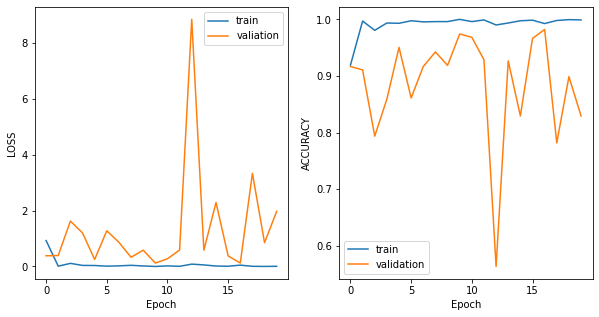

In [13]:
# accuracy, loss 그래프
fig, axes = plt.subplots(1,2, figsize=(10, 5))

## Accuracy
axes[0].plot(hist.history['loss'], label='train')
axes[0].plot(hist.history['val_loss'], label='valiation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('LOSS')
axes[0].legend()

## Loss
axes[1].plot(hist.history['acc'], label='train')
axes[1].plot(hist.history['val_acc'], label='validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('ACCURACY')
axes[1].legend()

plt.show()

In [14]:
# 모델 가중치 적용
model.load_weights(checkpoint_path)

In [15]:
# 모델 저장
model.save('rps.h5')